# 必要パッケージ

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import feather


# 関数

In [2]:
def metric_auc(y, pred):
    fpr, tpr, thresholds = roc_curve(y, pred)
    return auc(fpr, tpr)  

# version指定

In [3]:
version = "f04"

In [4]:
# train = feather.read_dataframe(f'../data/processed/train_processed_{version}.feather')
# test = feather.read_dataframe(f'../data/processed/test_processed_{version}.feather')

In [5]:
train = pd.read_csv('../data/processed/train_processed_f04.csv')
test = pd.read_csv('../data/processed/test_processed_f04.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (417,421,458,461) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (416,420,457,460) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 時系列でソート

In [6]:
train_sorted = train.sort_values('TransactionDT')

# カテゴリ指定

In [7]:
# TODO この部分も前のファイルから受け渡したい
categorical_features = [
            'id_12',
            'id_13', 
            'id_14', 
            'id_15', 
            'id_16',
            'id_17', 
            'id_18',
            'id_19',
            'id_20', 
            'id_21',
            'id_22',
            'id_23',
            'id_24',
            'id_25', 
            'id_26',
            'id_27', 
            'id_28', 
            'id_29',
            'id_30',
            'id_31',
            'id_32', 
            'id_33',
            'id_34',
            'id_35', 
            'id_36', 
            'id_37', 
            'id_38',
            'DeviceType', 
            'DeviceInfo',
            'card1', 
            'card2', 
            'card3', 
            'card4',
            'card5',
            'card6',
            'addr1',
            'addr2',
            'M1',
            'M2', 
            'M3',
            'M4',
            'M5',
            'M6',
            'M7',
            'M8',
            'M9',
            'P_emaildomain',
            'R_emaildomain',
            'P_emaildomain_1', 
            'P_emaildomain_2',
            'P_emaildomain_3', 
            'R_emaildomain_1',
            'R_emaildomain_2', 
            'R_emaildomain_3',
            'ProductCD']

# カテゴリ型に変換

In [8]:
for column in categorical_features:
    train_sorted[column] = train_sorted[column].astype('category')
    test[column] = test[column].astype('category')

# trainとtestを整形

In [9]:
y = train_sorted["isFraud"]
train_id = train_sorted["TransactionID"]
test_id = test["TransactionID"]
train_sorted = train_sorted.drop(["isFraud", "TransactionID","TransactionDT", "istrain"], axis=1)
test = test.drop(["TransactionID","TransactionDT","istrain"], axis=1)

# パラメータを設定

In [10]:
# LightGBM parameters
params = {
        'boosting_type' : 'dart',
        'objective' : 'binary',
        'metric' : 'auc',
        'num_leaves' : 256,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        'learning_rate' :  0.03,
        'feature_fraction' : 0.5,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'random_state':0,
        "verbosity": 0
}

In [11]:
early_stopping_rounds_sample = 10
num_rounds_sample = 50
# sampling_strategy=0.2
verbose=100

# 特徴選択のための実行(検証はホールドアウト)

In [12]:
X = train_sorted
y = y

columns = X.columns

# 学習データと検証データに分割する
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.2,shuffle = False,random_state = 0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# train
model = lgb.train(params,
            lgb_train,
            num_boost_round=num_rounds_sample,
            valid_sets=lgb_eval,
            early_stopping_rounds=early_stopping_rounds_sample)


# 検証データを予測する
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)

# AUC算出
auc_train = metric_auc(y_train, y_pred_train)
auc_test = metric_auc(y_valid, y_pred_valid)

#重要度算出
importance_df = pd.DataFrame()
importance_df["feature"] = columns
importance_df["importance"] = model.feature_importance(importance_type='gain')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.821144


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's auc: 0.844815
[3]	valid_0's auc: 0.85963
[4]	valid_0's auc: 0.866454
[5]	valid_0's auc: 0.869623
[6]	valid_0's auc: 0.870839
[7]	valid_0's auc: 0.873074
[8]	valid_0's auc: 0.875689
[9]	valid_0's auc: 0.875903
[10]	valid_0's auc: 0.877116
[11]	valid_0's auc: 0.878747
[12]	valid_0's auc: 0.880095
[13]	valid_0's auc: 0.881412
[14]	valid_0's auc: 0.88297
[15]	valid_0's auc: 0.88275
[16]	valid_0's auc: 0.883277
[17]	valid_0's auc: 0.8836
[18]	valid_0's auc: 0.88367
[19]	valid_0's auc: 0.883731
[20]	valid_0's auc: 0.884049
[21]	valid_0's auc: 0.884229
[22]	valid_0's auc: 0.884204
[23]	valid_0's auc: 0.884264
[24]	valid_0's auc: 0.884778
[25]	valid_0's auc: 0.884763
[26]	valid_0's auc: 0.885186
[27]	valid_0's auc: 0.885605
[28]	valid_0's auc: 0.885609
[29]	valid_0's auc: 0.885522
[30]	valid_0's auc: 0.885812
[31]	valid_0's auc: 0.88579
[32]	valid_0's auc: 0.886019
[33]	valid_0's auc: 0.886006
[34]	valid_0's auc: 0.885872
[35]	valid_0's auc: 0.88578
[36]	valid_0's auc: 0.885942
[

# 重要度一覧(反復回数が少ないとき)

Text(0.5, 1.0, 'LGB Features (avg over folds)')

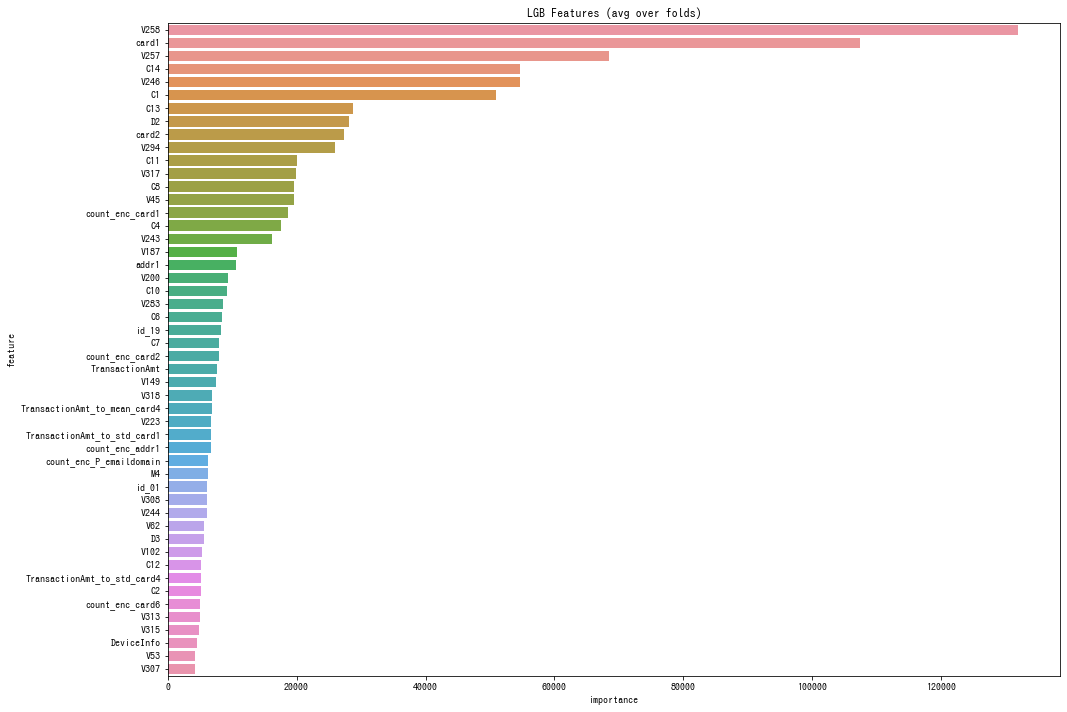

In [13]:
cols = importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance",
    ascending=False
).index[0:50]
best_features = importance_df.loc[importance_df.feature.isin(cols)]
plt.figure(figsize=(16,12))

sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

In [15]:
feature_df = importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance",
            ascending=False
        )

# 特徴量数を見ながら閾値を決定

In [16]:
(feature_df["importance"]  >=150).sum()

345

In [17]:
feature_list = list(feature_df[feature_df["importance"]  >= 150].index)

# 選択した特徴だけで再学習

In [18]:
train_sorted = train_sorted[feature_list]
test = test[feature_list]

In [19]:
early_stopping_rounds = 0
num_rounds = 2000
# sampling_strategy=0.2
verbose=100

In [20]:
%%time
X = train_sorted
y = y

columns = X.columns

# 学習データと検証データに分割する
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.2,shuffle = False,random_state = 0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# train
model = lgb.train(params,
            lgb_train,
            num_boost_round=num_rounds,
            valid_sets=lgb_eval,
            early_stopping_rounds=early_stopping_rounds)

# 検証データを予測する
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)

# AUC算出
auc_train = metric_auc(y_train, y_pred_train)
auc_test = metric_auc(y_valid, y_pred_valid)

#重要度算出
importance_df = pd.DataFrame()
importance_df["feature"] = columns
importance_df["importance"] = model.feature_importance(importance_type='gain')


[1]	valid_0's auc: 0.820611
[2]	valid_0's auc: 0.831426
[3]	valid_0's auc: 0.856256
[4]	valid_0's auc: 0.861563
[5]	valid_0's auc: 0.865062
[6]	valid_0's auc: 0.870573
[7]	valid_0's auc: 0.871546
[8]	valid_0's auc: 0.873304
[9]	valid_0's auc: 0.873881
[10]	valid_0's auc: 0.874782
[11]	valid_0's auc: 0.874656
[12]	valid_0's auc: 0.876123
[13]	valid_0's auc: 0.8768
[14]	valid_0's auc: 0.878299
[15]	valid_0's auc: 0.878797
[16]	valid_0's auc: 0.879305
[17]	valid_0's auc: 0.87945
[18]	valid_0's auc: 0.879409
[19]	valid_0's auc: 0.879703
[20]	valid_0's auc: 0.880261
[21]	valid_0's auc: 0.880607
[22]	valid_0's auc: 0.880913
[23]	valid_0's auc: 0.881336
[24]	valid_0's auc: 0.881639
[25]	valid_0's auc: 0.881737
[26]	valid_0's auc: 0.882534
[27]	valid_0's auc: 0.882539
[28]	valid_0's auc: 0.882493
[29]	valid_0's auc: 0.88224
[30]	valid_0's auc: 0.883215
[31]	valid_0's auc: 0.883143
[32]	valid_0's auc: 0.883089
[33]	valid_0's auc: 0.883223
[34]	valid_0's auc: 0.883203
[35]	valid_0's auc: 0.88413

KeyboardInterrupt: 

# 再学習

In [21]:
# rus = RandomUnderSampler(sampling_strategy=0.2, random_state=0)
# X_trn, y_trn = rus.fit_resample(train, y)


trn_data = lgb.Dataset(
    X,
    label= y
)
num_round = model.best_iteration
model = lgb.train(
    params=params,
    train_set=trn_data,
    num_boost_round=num_round,
    verbose_eval=verbose,
)

Text(0.5, 1.0, 'LGB Features (avg over folds)')

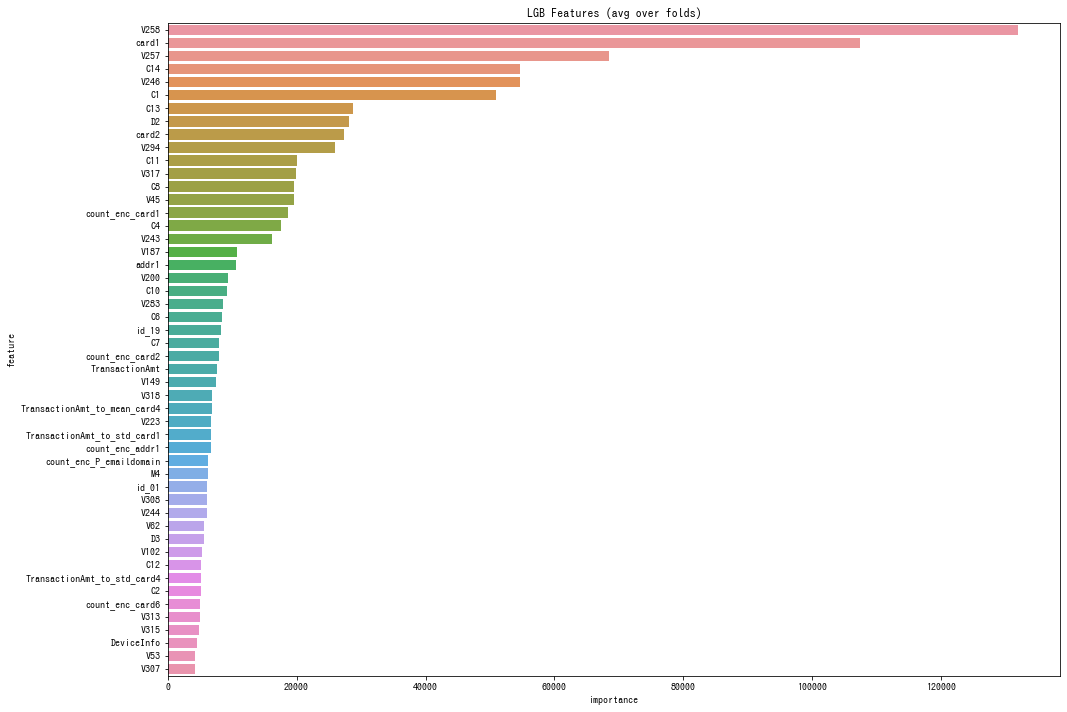

In [21]:
cols = importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance",
    ascending=False
).index[0:50]
best_features = importance_df.loc[importance_df.feature.isin(cols)]
plt.figure(figsize=(16,12))

sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

# 予測を実行

In [23]:
predict = model.predict(test, num_iteration=num_round)

In [35]:
predict

array([0.00880327, 0.01492235, 0.01236611, ..., 0.01860856, 0.0127432 ,
       0.01576208])

In [24]:
sub = pd.read_csv("../data/raw/sample_submission.csv")
sub["isFraud"] = predict

In [25]:
sub.head()

,TransactionID,isFraud
0,3663549,0.000826
1,3663550,0.003291
2,3663551,0.000506
3,3663552,0.000788
4,3663553,0.001706


In [26]:
sub.to_csv(f'../model/submit/sub{version}.csv', index=False)

In [42]:
# 提出コマンド
# kaggle competitions submit -c ieee-fraud-detection -f subfXX.csv -m "Message"

# 結果の記録

In [27]:
cv_score =  0.926004
leader_board_score = 0.9386
cv_strategy = "timesort_hold-out(8:2)"
submit = version

feature_select = 1
under_sample = 0

In [28]:
info = {
    "early_stopping_rounds": early_stopping_rounds,
    "num_rounds": num_rounds,
    "feature_select": feature_select,
    "under_sample": under_sample,
}

In [29]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': 'auc',
 'num_leaves': 256,
 'learning_rate': 0.05,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'random_state': 0,
 'verbosity': 0}

/opt/conda/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


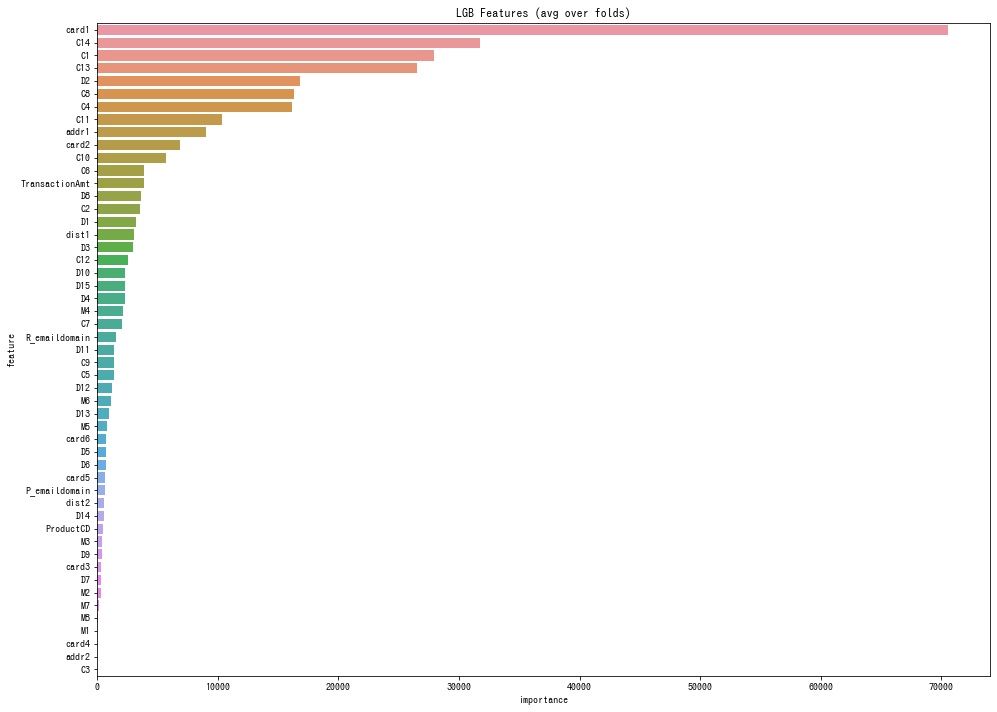

In [30]:
import mlflow
import mlflow.sklearn
import tempfile
import os
import json

mlflow.set_tracking_uri('http://mlflow.wp16005.wing.sysrdc.com')
# アーティファクトアップロードのための設定(アップロード先がs3互換のminioを使用しているため必須)
os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio.wp16005.wing.sysrdc.com'

# S3アカウントの設定(see. https://mlflow.org/docs/latest/tracking.html#amazon-s3)
# とりあえず使うために環境変数を定義
os.environ['AWS_ACCESS_KEY_ID']='mlflowcommon'
os.environ['AWS_SECRET_ACCESS_KEY']='mlflowcommon-secret'
mlflow.set_experiment("IEEE-CIS")
with mlflow.start_run():
    with tempfile.TemporaryDirectory() as dname:
        # lightgbmの設定パラメータ
        save_file = os.path.join(dname, "parameters.json")
        with open(save_file, "w") as f:
            json.dump(params, f)
        mlflow.log_artifact(save_file)
        # そのほかのモデル再現に必要なパラメータ
        save_file = os.path.join(dname, "info.json")
        with open(save_file, "w") as f:
            json.dump(info, f)
        mlflow.log_artifact(save_file)
        # 学習時のfeature iportance
        save_file = os.path.join(dname, "importance.png")
        best_features = importance_df.loc[0:50]
        plt.figure(figsize=(16,12))

        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LGB Features (avg over folds)')
        plt.savefig(save_file)
        mlflow.log_artifact(save_file)
    
    mlflow.log_param("cv_strategy", cv_strategy)
    mlflow.log_param("sub", submit)
    
    mlflow.log_metric("auc", cv_score)
    mlflow.log_metric("lb_auc", leader_board_score)
    
    mlflow.sklearn.log_model(model, "model")